In [1]:
%matplotlib inline


<div class="alert alert-block alert-info">
<b>Credits:</b> This is a modified example from SimPEG.xyz </div>

# Linear Least-Squares Inversion with Wavelet-Based-regularization

Here we demonstrate the basics of inverting data with SimPEG by considering a
linear inverse problem. We formulate the inverse problem as a least-squares
optimization problem. For this tutorial, we focus on the following:

    - Defining the forward problem
    - Defining the inverse problem (data misfit, regularization, optimization)
    - Specifying directives for the inversion
    - Recovering a set of model parameters which explains the observations


## Import Modules




In [2]:
import matplotlib.pyplot as plt
import numpy as np
from SimPEG import (
    simulation,
    maps,
    data_misfit,
    directives,
    optimization,
    inverse_problem,
    inversion,
)
from discretize import TensorMesh

from wbi import wavelet_regularization as regularization
# sphinx_gallery_thumbnail_number = 3

## Defining the Model and Mapping

Here we generate a synthetic model and a mappig which goes from the model
space to the row space of our linear operator.




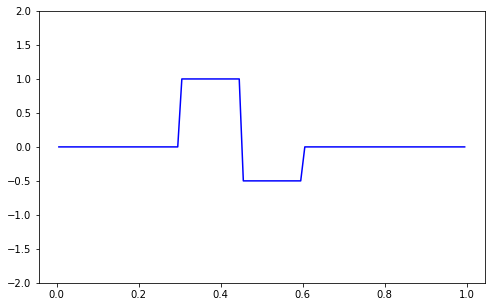

In [3]:
nParam = 100  # Number of model parameters

# A 1D mesh is used to define the row-space of the linear operator.
mesh = TensorMesh([nParam])

# Creating the true model
true_model = np.zeros(mesh.nC)
true_model[mesh.vectorCCx > 0.3] = 1.0
true_model[mesh.vectorCCx > 0.45] = -0.5
true_model[mesh.vectorCCx > 0.6] = 0

# Mapping from the model space to the row space of the linear operator
model_map = maps.IdentityMap(mesh)

# Plotting the true model
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(mesh.vectorCCx, true_model, "b-")
ax.set_ylim([-2, 2])
plt.show()

## Defining the Linear Operator

Here we define the linear operator with dimensions (nData, nParam). In practive,
you may have a problem-specific linear operator which you would like to construct
or load here.




Text(0.5, 1.0, 'Columns of matrix G')

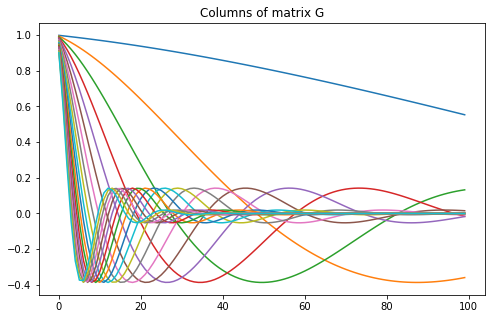

In [4]:
# Number of data observations (rows)
nData = 20

# Create the linear operator for the tutorial. The columns of the linear operator
# represents a set of decaying and oscillating functions.
jk = np.linspace(1.0, 60.0, nData)
p = -0.25
q = 0.25


def g(k):
    return np.exp(p * jk[k] * mesh.vectorCCx) * np.cos(
        np.pi * q * jk[k] * mesh.vectorCCx
    )


G = np.empty((nData, nParam))

for i in range(nData):
    G[i, :] = g(i)

# Plot the columns of G
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
for i in range(G.shape[0]):
    ax.plot(G[i, :])

ax.set_title("Columns of matrix G")

## Defining the Simulation

The simulation defines the relationship between the model parameters and
predicted data.




In [5]:
sim = simulation.LinearSimulation(mesh, G=G, model_map=model_map)

/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/SimPEG/simulation.py:546: UserWarning: G has not been implemented for the simulation
  warnings.warn("G has not been implemented for the simulation")


## Predict Synthetic Data

Here, we use the true model to create synthetic data which we will subsequently
invert.




In [6]:
# Standard deviation of Gaussian noise being added
std = 0.01
np.random.seed(1)

# Create a SimPEG data object
data_obj = sim.make_synthetic_data(true_model, relative_error=std, add_noise=True)


## Define the Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem




In [7]:
#
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.


dmis = data_misfit.L2DataMisfit(simulation=sim, data=data_obj)

# Define the regularization (model objective function).

# Play here with the wav-parameter
# - db1 = blocky
# - db2, db3, db4 = rather sharp
# - db5+ = rather smooth

reg = regularization.WaveletRegularization1D(mesh, wav="db6")

# Define how the optimization problem is solved.
opt = optimization.InexactGaussNewton(maxIter=100, maxIterLS=20)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

# Here we define any directiveas that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit()

# The directives are defined as a list.
directives_list = [target_misfit]


## Setting a Starting Model and Running the Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.




In [8]:
inv = inversion.BaseInversion(inv_prob)

# Starting model
starting_model = np.random.rand(nParam)
starting_model = np.zeros(nParam)


# The inversion class is kinda broken
# Run inversion
recovered_model = inv.run(starting_model)


/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(


SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  1.00e+05  9.58e-03  1.00e+05    1.26e+06      0              
   1  1.00e+00  6.29e+04  2.00e-02  6.29e+04    7.20e+04      0              
   2  1.00e+00  2.93e+04  7.57e-02  2.93e+04    3.31e+04      0              


/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


   3  1.00e+00  1.87e+04  8.19e-02  1.87e+04    1.58e+05      0              
   4  1.00e+00  1.59e+04  7.59e-02  1.59e+04    2.10e+04      0              
   5  1.00e+00  1.49e+04  7.74e-02  1.49e+04    9.11e+04      0              
   6  1.00e+00  1.44e+04  7.47e-02  1.44e+04    5.25e+04      0              
   7  1.00e+00  1.38e+04  7.31e-02  1.38e+04    1.01e+05      0              
   8  1.00e+00  6.57e+03  5.14e-02  6.57e+03    2.21e+04      0   Skip BFGS  
   9  1.00e+00  4.96e+03  5.28e-02  4.96e+03    2.22e+04      0              
  10  1.00e+00  4.36e+03  5.42e-02  4.36e+03    6.78e+04      0              
  11  1.00e+00  3.51e+03  5.26e-02  3.51e+03    4.76e+04      0              
  12  1.00e+00  3.07e+03  5.49e-02  3.07e+03    3.62e+04      0              
  13  1.00e+00  2.41e+03  5.43e-02  2.41e+03    2.48e+04      0              
  14  1.00e+00  1.55e+03  4.81e-02  1.55e+03    3.26e+04      0   Skip BFGS  
  15  1.00e+00  1.41e+03  4.74e-02  1.41e+03    1.96e+04      0 

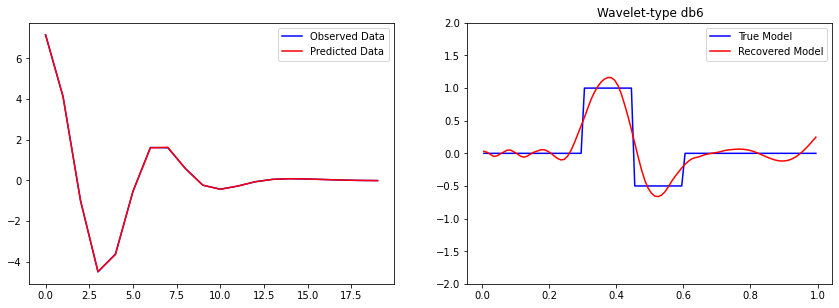

In [9]:
# Observed versus predicted data
fig, ax = plt.subplots(1, 2, figsize=(12 * 1.2, 4 * 1.2))
ax[0].plot(data_obj.dobs, "b-")
ax[0].plot(inv_prob.dpred, "r-")
ax[0].legend(("Observed Data", "Predicted Data"))

# True versus recovered model
ax[1].plot(mesh.vectorCCx, true_model, "b-")
ax[1].plot(mesh.vectorCCx, recovered_model, "r-")
ax[1].legend(("True Model", "Recovered Model"))
ax[1].set_ylim([-2, 2])
ax[1].set_title("Wavelet-type " + reg.wavelets.wav)

plt.show()

## Generate ensemble of inversion results

The callback on the InexactGaussNewton Optimization was replaced.
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+03  1.00e+05  8.85e-03  1.00e+05    1.26e+06      0              
   1  1.00e+03  6.29e+04  5.09e-02  6.30e+04    7.20e+04      0              
   2  1.00e+03  2.93e+04  2.27e-01  2.95e+04    3.22e+04      0              


/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


   3  1.00e+03  1.90e+04  2.73e-01  1.92e+04    4.81e+04      0   Skip BFGS  
   4  1.00e+03  1.63e+04  2.71e-01  1.66e+04    2.01e+04      0              
   5  1.00e+03  1.45e+04  2.55e-01  1.48e+04    3.54e+04      0              
   6  1.00e+03  1.21e+04  2.69e-01  1.24e+04    2.86e+04      0              
   7  1.00e+03  8.02e+03  3.01e-01  8.32e+03    2.03e+04      0   Skip BFGS  
   8  1.00e+03  6.79e+03  2.99e-01  7.09e+03    2.38e+04      0              
   9  1.00e+03  5.47e+03  3.48e-01  5.81e+03    2.63e+04      0              
  10  1.00e+03  4.63e+03  3.25e-01  4.95e+03    2.82e+04      0              
  11  1.00e+03  4.33e+03  3.50e-01  4.68e+03    2.49e+04      0              
  12  1.00e+03  4.21e+03  3.46e-01  4.56e+03    7.22e+04      0              
  13  1.00e+03  4.14e+03  3.53e-01  4.49e+03    3.32e+04      0              
  14  1.00e+03  4.11e+03  3.53e-01  4.46e+03    4.80e+04      0   Skip BFGS  
  15  1.00e+03  4.10e+03  3.54e-01  4.45e+03    3.63e+04      0 

/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/SimPEG/directives/directives.py:60: UserWarning: InversionDirective TargetMisfit has switched to a new inversion.
  warnings.warn(
/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


   3  1.00e+04  1.85e+04  2.18e-01  2.07e+04    2.51e+04      0   Skip BFGS  
   4  1.00e+04  1.41e+04  2.21e-01  1.63e+04    3.87e+04      0              
   5  1.00e+04  1.11e+04  1.81e-01  1.29e+04    2.42e+04      0              
   6  1.00e+04  8.39e+03  2.60e-01  1.10e+04    3.43e+04      0              
   7  1.00e+04  6.17e+03  2.92e-01  9.09e+03    3.48e+04      0   Skip BFGS  
   8  1.00e+04  4.79e+03  2.63e-01  7.41e+03    2.99e+04      0   Skip BFGS  
   9  1.00e+04  5.11e+03  1.77e-01  6.88e+03    3.95e+04      0              
  10  1.00e+04  4.42e+03  2.05e-01  6.47e+03    2.98e+04      0              
  11  1.00e+04  4.49e+03  1.94e-01  6.43e+03    3.33e+04      1              
  12  1.00e+04  4.46e+03  1.61e-01  6.07e+03    4.65e+04      0              
  13  1.00e+04  4.11e+03  1.91e-01  6.02e+03    4.05e+04      0              
  14  1.00e+04  3.68e+03  2.15e-01  5.83e+03    4.46e+04      0              
  15  1.00e+04  3.58e+03  1.99e-01  5.57e+03    4.49e+04      0 

/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/SimPEG/directives/directives.py:60: UserWarning: InversionDirective TargetMisfit has switched to a new inversion.
  warnings.warn(
/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


   3  1.00e+04  1.83e+04  1.43e-01  1.97e+04    2.21e+04      0   Skip BFGS  
   4  1.00e+04  1.40e+04  1.62e-01  1.57e+04    2.86e+04      0              
   5  1.00e+04  1.15e+04  1.17e-01  1.27e+04    2.55e+04      0              
   6  1.00e+04  8.69e+03  1.70e-01  1.04e+04    1.89e+04      0              
   7  1.00e+04  6.10e+03  1.82e-01  7.92e+03    2.05e+04      0   Skip BFGS  
   8  1.00e+04  5.00e+03  1.66e-01  6.66e+03    1.55e+04      0   Skip BFGS  
   9  1.00e+04  4.53e+03  1.44e-01  5.96e+03    2.16e+04      1              
  10  1.00e+04  4.48e+03  1.04e-01  5.52e+03    1.59e+04      0              
  11  1.00e+04  3.81e+03  1.11e-01  4.92e+03    1.42e+04      0              
  12  1.00e+04  3.23e+03  1.42e-01  4.64e+03    1.73e+04      1              
  13  1.00e+04  2.90e+03  1.32e-01  4.22e+03    1.62e+04      0              
  14  1.00e+04  2.31e+03  1.61e-01  3.93e+03    2.00e+04      1              
  15  1.00e+04  1.98e+03  1.58e-01  3.56e+03    4.49e+04      0 

/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/SimPEG/directives/directives.py:60: UserWarning: InversionDirective TargetMisfit has switched to a new inversion.
  warnings.warn(
/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


   1  1.00e+04  6.29e+04  2.07e-02  6.31e+04    7.16e+04      0              
   2  1.00e+04  3.06e+04  1.09e-01  3.17e+04    2.80e+04      0              
   3  1.00e+04  1.84e+04  1.22e-01  1.96e+04    2.15e+04      0   Skip BFGS  
   4  1.00e+04  1.41e+04  1.45e-01  1.55e+04    2.93e+04      0              
   5  1.00e+04  1.14e+04  1.01e-01  1.24e+04    1.87e+04      0              
   6  1.00e+04  8.49e+03  1.47e-01  9.95e+03    1.84e+04      0              
   7  1.00e+04  5.99e+03  1.53e-01  7.53e+03    1.71e+04      0   Skip BFGS  
   8  1.00e+04  4.92e+03  1.41e-01  6.33e+03    1.60e+04      0   Skip BFGS  
   9  1.00e+04  4.54e+03  1.07e-01  5.62e+03    1.70e+04      1              
  10  1.00e+04  4.13e+03  1.28e-01  5.41e+03    2.27e+04      0              
  11  1.00e+04  3.52e+03  1.13e-01  4.64e+03    1.59e+04      0              
  12  1.00e+04  3.31e+03  1.00e-01  4.31e+03    2.03e+04      0              
  13  1.00e+04  3.10e+03  1.09e-01  4.19e+03    1.50e+04      0 

/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/SimPEG/directives/directives.py:60: UserWarning: InversionDirective TargetMisfit has switched to a new inversion.
  warnings.warn(
/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


   0  1.00e+04  1.00e+05  9.39e-03  1.00e+05    1.26e+06      0              
   1  1.00e+04  6.29e+04  2.35e-02  6.32e+04    7.21e+04      0              
   2  1.00e+04  3.06e+04  7.37e-02  3.13e+04    2.79e+04      0              
   3  1.00e+04  1.84e+04  8.77e-02  1.93e+04    2.06e+04      0   Skip BFGS  
   4  1.00e+04  1.39e+04  1.07e-01  1.50e+04    2.82e+04      0              
   5  1.00e+04  1.15e+04  7.35e-02  1.22e+04    1.94e+04      0              
   6  1.00e+04  8.65e+03  1.12e-01  9.77e+03    1.70e+04      0              
   7  1.00e+04  6.15e+03  1.32e-01  7.46e+03    1.38e+04      0   Skip BFGS  
   8  1.00e+04  4.97e+03  1.24e-01  6.21e+03    1.47e+04      0   Skip BFGS  
   9  1.00e+04  4.78e+03  1.16e-01  5.93e+03    1.97e+04      0              
  10  1.00e+04  3.96e+03  8.94e-02  4.85e+03    1.60e+04      0              
  11  1.00e+04  3.59e+03  8.02e-02  4.39e+03    1.26e+04      1              
  12  1.00e+04  3.25e+03  1.03e-01  4.28e+03    1.42e+04      0 

/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/SimPEG/directives/directives.py:60: UserWarning: InversionDirective TargetMisfit has switched to a new inversion.
  warnings.warn(
/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(
/Users/u0102388/miniconda3/envs/rosetta/lib/python3.8/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting dia_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


The callback on the InexactGaussNewton Optimization was replaced.
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+04  1.00e+05  9.58e-03  1.00e+05    1.26e+06      0   Skip BFGS  
   1  1.00e+04  6.29e+04  1.99e-02  6.31e+04    7.15e+04      0   Skip BFGS  
   2  1.00e+04  3.06e+04  7.97e-02  3.14e+04    2.78e+04      0              
   3  1.00e+04  1.85e+04  1.09e-01  1.96e+04    2.10e+04      0   Skip BFGS  
   4  1.00e+04  1.42e+04  1.26e-01  1.55e+04    2.84e+04      0              
   5  1.00e+04  1.17e+04  9.14e-02  1.26e+04    2.00e+04      0       

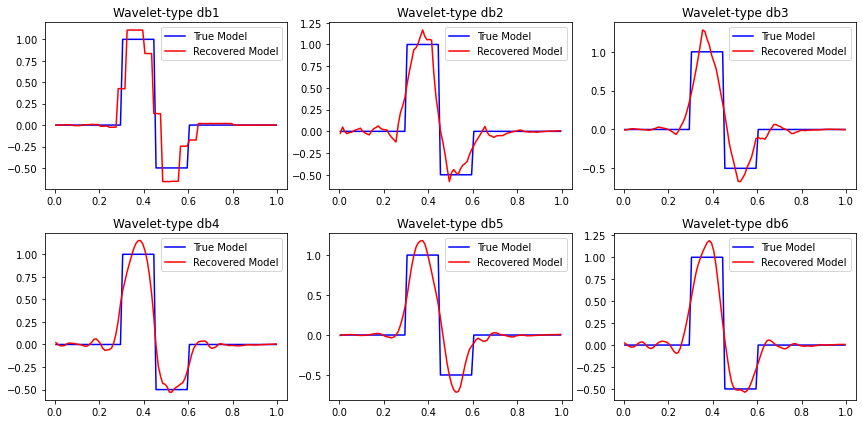

In [10]:
fig, ax_ls = plt.subplots(2,3, figsize=(12, 6))
wav_list = ['db1', 'db2', 'db3', 'db4', 'db5', 'db6']
betalist = [1e3, 1e4, 1e4, 1e4, 1e4, 1e4]
for idx, wav in enumerate(wav_list):
    reg = regularization.WaveletRegularization1D(mesh, wav=wav)
    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)
    inv_prob.beta = betalist[idx]
    inv = inversion.BaseInversion(inv_prob, directives_list)

    recovered_model = inv.run(starting_model)

    ax_ls[idx//3, idx%3].plot(mesh.vectorCCx, true_model, "b-")
    ax_ls[idx//3, idx%3].plot(mesh.vectorCCx, recovered_model, "r-")
    ax_ls[idx//3, idx%3].legend(("True Model", "Recovered Model"))
    # ax[1].set_ylim([-2, 2])
    ax_ls[idx//3, idx%3].set_title("Wavelet-type " + reg.wavelets.wav)
plt.tight_layout()
plt.show()